# 4. Train/Test Splitting, Overfitting/Underfitting and Generalization

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Mock dataset generation

As in Notebook 3., we will generate prices $ y_i $ as a polynomial function  of the surface $ x_i $.

In this notebook, we will assume that the function f(x), giving the price of an appartment with surface $ x $, will be defined as

$$ f(x) = 100000 + 14373x + 3x^3. $$

In addition, we will add a random noise to the final pricing, with a $ +/- 5\% $ drift as before.

In [2]:
# All helper functions
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this has changed and is now a polynomial function.
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def generate_datasets(n_points, min_surf, max_surf):
    x = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    y = np.array([price(i) for i in x])
    return x, y
def linreg_matplotlib(a, b, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = a*x + b
    return x, y
def loss_mse(a, b, x, y):
    val =  np.sum((y - (a*x + b))**2)/x.shape[0]
    return '{:.2e}'.format(val)

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
min_surf = 40
max_surf = 150
np.random.seed(27)
n_points = 50
inputs, outputs = generate_datasets(n_points, min_surf, max_surf)
print(inputs)
print(outputs)

[ 86.83 129.6  120.89 135.48  82.17 147.74 138.25  63.07 121.6  112.95
 137.55 134.38 122.42 135.72  60.54  75.81  81.02 127.31  56.62  58.69
  48.93  73.57 126.16  57.92  47.77 117.12  59.91 105.88  85.68  96.49
  64.27 119.81 133.44 142.18 120.95  92.42  94.22 105.4   48.36  52.92
 146.31 104.17  50.17  41.5  132.06 140.63 117.5   82.57 117.63 141.56]
[ 3.171633  8.805667  7.166722 10.224944  3.195151 11.87205  10.206911
  1.676214  7.954078  5.696169 10.049157  9.588631  7.968783  8.827882
  1.693317  2.6239    3.094831  7.700582  1.597057  1.489182  1.247223
  2.166055  8.212138  1.627403  1.12722   6.560241  1.450404  5.072051
  3.031968  3.938955  1.782147  7.652644  8.58658  11.518957  7.088832
  3.563134  3.702923  5.087156  1.071143  1.308982 12.111945  5.438864
  1.088438  0.998857  9.333922  9.801835  7.095279  2.982004  6.953392
 11.129658]


### Train-Test Splitting

This time, we will perform a train-test split. Remember, the goal of supervised learning is to build a model that performs well (or in other words, generalizes well) on new unseen data. If you have new data, it is a good idea to use this data to see how your model performs on it. In practice, however, the problem often is that you may not have new data, but you can simulate this experience with a procedure like a train-test split.

The core idea is the following:
- We will use a large part (we will use 80% to demonstrate, here) of the dataset to train our model and decide its parameters,
- We will then use the remaining data (20%), to evaluate the performance of the model and decide if it generalizes well, or overfits.

We can simply perform a train-test split, using slicing, as shown below.

You may also use the train-test split functions from sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [4]:
# 80% of the samples will be used for training,
# and the remaining 20% will be used to evaluate generalization/overfitting.
ratio_train = 0.8
split_index = int(n_points*ratio_train)
# Training inputs and outputs
train_inputs = inputs[:split_index]
train_outputs = outputs[:split_index]
# Testing inputs and outputs
test_inputs = inputs[split_index:]
test_outputs = outputs[split_index:]
# Display
print(train_inputs)
print(train_outputs)
print(test_inputs)
print(test_outputs)

[ 86.83 129.6  120.89 135.48  82.17 147.74 138.25  63.07 121.6  112.95
 137.55 134.38 122.42 135.72  60.54  75.81  81.02 127.31  56.62  58.69
  48.93  73.57 126.16  57.92  47.77 117.12  59.91 105.88  85.68  96.49
  64.27 119.81 133.44 142.18 120.95  92.42  94.22 105.4   48.36  52.92]
[ 3.171633  8.805667  7.166722 10.224944  3.195151 11.87205  10.206911
  1.676214  7.954078  5.696169 10.049157  9.588631  7.968783  8.827882
  1.693317  2.6239    3.094831  7.700582  1.597057  1.489182  1.247223
  2.166055  8.212138  1.627403  1.12722   6.560241  1.450404  5.072051
  3.031968  3.938955  1.782147  7.652644  8.58658  11.518957  7.088832
  3.563134  3.702923  5.087156  1.071143  1.308982]
[146.31 104.17  50.17  41.5  132.06 140.63 117.5   82.57 117.63 141.56]
[12.111945  5.438864  1.088438  0.998857  9.333922  9.801835  7.095279
  2.982004  6.953392 11.129658]


As before, we provide a display, showing the data, with two different colors for train and test datasets.

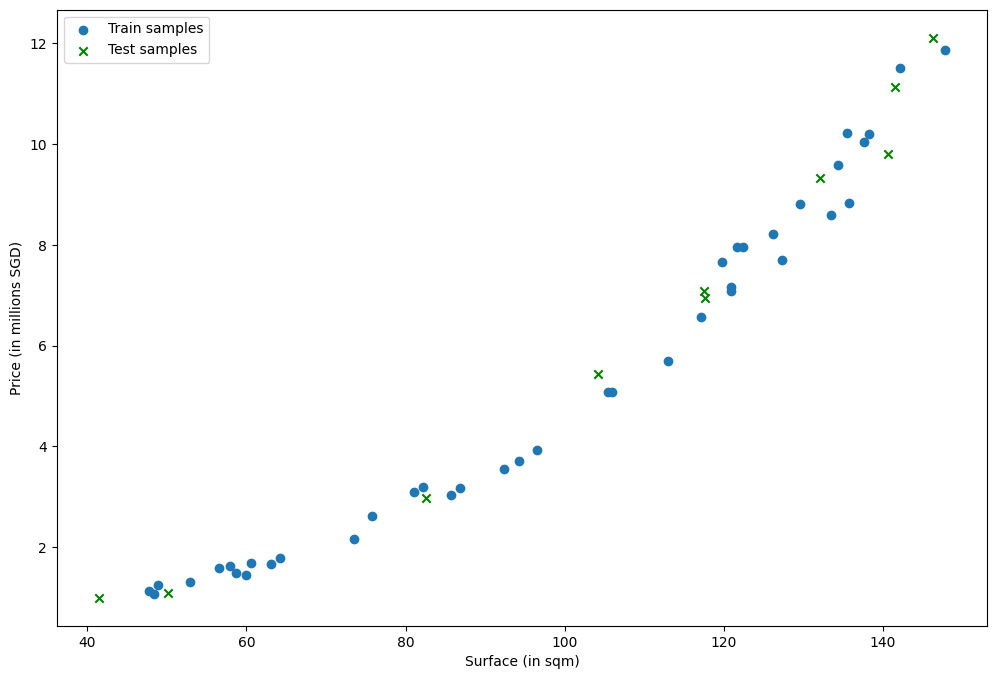

In [5]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'g', marker = "x", label = 'Test samples')
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Display
plt.legend(loc = 'best')
plt.show()

In [6]:
# Training a Polynomial Regressor
n_degree = 6
sk_inputs = np.array(train_inputs).reshape(-1, 1)
sk_outputs = np.array(train_outputs)
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk = poly_reg_model.coef_
b_sk = poly_reg_model.intercept_
print(a_sk, b_sk)

[-5.31103644e+00  1.55941662e-01 -2.34706297e-03  1.92370550e-05
 -8.12548986e-08  1.38734052e-10] 73.25495081585393


In [7]:
# Polynomial regression of the helper function that will
# help get points for the upcoming matplotlib displays.
def polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in x])
    return x, y

### Checking losses on train and test sets

In order to check for overfitting, a good idea is to check the losses (in our case, the MSE, like before), but calculate them separately for both the training and testing samples.

We provide a helper function, **loss_mse_poly()**, to calculate MSE losses in the case of polynomial regressors below. 

In [8]:
# Mean square error as a loss function for polynomial regression
# Displaying loss using exponential notation (XXXe-YYY)
def loss_mse_poly(poly_reg_model, n_degree, inputs, outputs):
    pred = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in inputs])
    losses = (pred - outputs)**2
    val = sum(losses)/inputs.shape[0]
    return '{:.2e}'.format(val)

In general, the train loss has a smaller value than the test one, but they should still remain on similar orders of magnitude.

Our polynomial regressor, here, is overfitting, which is why its loss on the test samples, is much higher than the loss on the train samples.

In [9]:
loss_train = loss_mse_poly(poly_reg_model, n_degree, train_inputs, train_outputs)
print(loss_train)
loss_test = loss_mse_poly(poly_reg_model, n_degree, test_inputs, test_outputs)
print(loss_test)

9.69e-02
1.60e-01


If we run the same operation on a polynomial regressor with degree $ M = 3 $, which is not overfitting, we will observe that both the train and test losses are one the same order of magnitude (which is usually a good sign suggesting that no overfitting happened).

In [10]:
# Training a Polynomial Regressor
n_degree2 = 3
sk_inputs2 = np.array(train_inputs).reshape(-1, 1)
sk_outputs2 = np.array(train_outputs)
sk_poly2 = PolynomialFeatures(degree = n_degree2, include_bias = False)
sk_poly_inputs2 = sk_poly2.fit_transform(sk_inputs2.reshape(-1, 1))
poly_reg_model2 = LinearRegression()
poly_reg_model2.fit(sk_poly_inputs2, sk_outputs2)
a_sk2 = poly_reg_model2.coef_
b_sk2 = poly_reg_model2.intercept_
print(a_sk2, b_sk2)

[-2.08734379e-02  3.34415164e-04  2.07651310e-06] 1.1872436793871621


In [11]:
loss_train2 = loss_mse_poly(poly_reg_model2, n_degree2, train_inputs, train_outputs)
print(loss_train2)
loss_test2 = loss_mse_poly(poly_reg_model2, n_degree2, test_inputs, test_outputs)
print(loss_test2)

1.00e-01
1.40e-01


### Visualizing the overfitting and a note on losses

As expected, the red model (poly reg with $ M = 6 $) is showing signs of overfitting, on the low surface values. Technically, this could be explained by the fact that barely any samples for surfaces 40-50 sqm were present in the train dataset. For this reason, the model did not properly learn to predict values for appartments of this surface range. The test set, on the other hand, contains a sample in this surface range, which will be somewhat mispredected. For that reason, both the test and train loss of the overfitting model will have somewhat different values, as the train and test datasets do not "follow the same distribution".

The black model, however, while having a train loss higher than the red model, generalizes better. This is explicitely confirmed by the test loss being lower for the black model, than the red one.

And that is an important message: while the **train loss** is important to confirm the model has correctly learnt to fit the training samples, the important performance metric, which allows to assess a model and decide whether it is overfitting or not, is definitely the **test loss**.

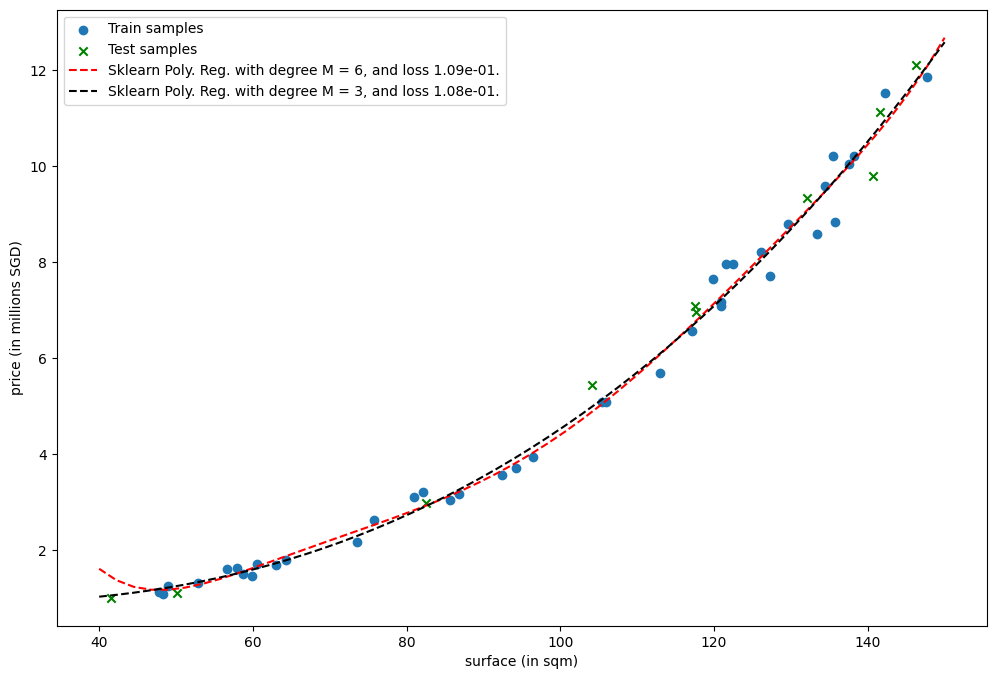

In [12]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'g', marker = "x", label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")


# Optimal poly reg (with degree M = 6)
polyreg_dataset1_inputs, polyreg_dataset1_outputs = polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points)
loss1 = loss_mse_poly(poly_reg_model, n_degree, inputs, outputs)
legend1 = "Sklearn Poly. Reg. with degree M = 6, and loss {}.".format(loss1)
plt.plot(polyreg_dataset1_inputs, polyreg_dataset1_outputs, 'r--', label = legend1)

# Optimal poly reg (with degree M = 3)
polyreg_dataset2_inputs, polyreg_dataset2_outputs = polyreg_matplotlib(poly_reg_model2, n_degree2, min_surf, max_surf, n_points)
loss2 = loss_mse_poly(poly_reg_model2, n_degree2, inputs, outputs)
legend2 = "Sklearn Poly. Reg. with degree M = 3, and loss {}.".format(loss2)
plt.plot(polyreg_dataset2_inputs, polyreg_dataset2_outputs, 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### Predicting, to confirm overfitting

As in Notebook 3, we can check the performance of our two polynomial regressor models and assess overfitting, by using them to predict prices of unseen appartments.

We will also reuse our helper function, **theoretical_values()**.

In [13]:
# Helper function for prediction evaluation
# Return interval of min and max values, along with avg value for given surface
def theoretical_values(surface):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

Our overfitting model typical has difficulties estimating prices for appartments with surfaces above 140 sqm.

This time, it is underevaluating, as shown below.

In [14]:
new_appt_surface1 = 40
pred_price1 = poly_reg_model.predict(np.array([[(new_appt_surface1)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price1, theoretical_values(new_appt_surface1))
new_appt_surface2 = 98
pred_price2 = poly_reg_model.predict(np.array([[(new_appt_surface2)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price2, theoretical_values(new_appt_surface2))
new_appt_surface3 = 150
pred_price3 = poly_reg_model.predict(np.array([[(new_appt_surface3)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price3, theoretical_values(new_appt_surface3))

1.6027365789562111 [0.780228, 0.86692, 0.9536120000000001]
4.181490005356167 [3.8989170000000004, 4.33213, 4.7653430000000006]
12.682146418724983 [11.142855, 12.38095, 13.619045000000002]


In [15]:
new_appt_surface1 = 40
pred_price1b = poly_reg_model2.predict(np.array([[(new_appt_surface1)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price1b, theoretical_values(new_appt_surface1))
new_appt_surface2 = 98
pred_price2b = poly_reg_model2.predict(np.array([[(new_appt_surface2)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price2b, theoretical_values(new_appt_surface2))
new_appt_surface3 = 150
pred_price3b = poly_reg_model2.predict(np.array([[(new_appt_surface3)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price3b, theoretical_values(new_appt_surface3))

1.0202672640842074 [0.780228, 0.86692, 0.9536120000000001]
4.307767518882862 [3.8989170000000004, 4.33213, 4.7653430000000006]
12.588800898864346 [11.142855, 12.38095, 13.619045000000002]


### What's next?

In the next notebook, we will discuss some techniques to attenuate the undesirable effects of overfitting, by implementing a ridge polynomial model.